In [1]:
import os
import sys
sys.path.append('./nn_model/')
sys.path.append('./rr_model/')
from nnModel import ShiftMLNN
from rrModel import ShiftMLRR, ShiftMLRR_dropout
from ase.io import read
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
import numpy as np
import json
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
model_v2_NN = ShiftMLNN(bodyorder='v2')
model_v2_RR = ShiftMLRR(bodyorder='v2')
model_v1_RR = ShiftMLRR(bodyorder='v1')
model_v1_NN = ShiftMLNN(bodyorder='v1')

In [11]:
frames = read("../../COSMO_project/Shiftml2/CSD-1k_test_md_w_shifts.xyz",index=":",format="extxyz")
#frames = read("../../COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")
tmp = []

for frame in frames:
    numbers = np.unique(frame.numbers)
    
    defined = True
    for number in numbers:
        if number not in [1,6,7,8,16]:
            defined = False
        else:
            continue
    
    if defined:
        tmp.append(frame)

frames = tmp
        
results = {}
for specie in [1,6,7,8]:
    tmp = []
    for frame in frames:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp.append(frame.arrays["CS_total"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results[specie] = np.hstack(tmp)   
for frame in frames: frame.wrap(eps=1e-12)

In [12]:
results_v2_NN = model_v2_NN.predict(frames)
results_v1_NN = model_v1_NN.predict(frames)
results_v2_RR = model_v2_RR.predict(frames)
results_v1_RR = model_v1_RR.predict(frames)

(37656, 16)
(33901, 16)
(3702, 16)
(6613, 16)
(37656, 16)
(33901, 16)
(3702, 16)
(6613, 16)


In [13]:
for specie in [1,6,7,8]:
    for result_tmp,ident in zip([results_v2_NN,results_v1_NN,results_v2_RR,results_v1_RR],["NN_v2","NN_v1","RR_v2","RR_v1"]):
        print("specie {} : model {} : error {}" .format(specie,ident,mean_squared_error(result_tmp[specie][:,0],results[specie],squared=False)))

specie 1 : model NN_v2 : error 0.6939327855215808
specie 1 : model NN_v1 : error 1.974466262802988
specie 1 : model RR_v2 : error 0.8219281177855147
specie 1 : model RR_v1 : error 4.730138955385111
specie 6 : model NN_v2 : error 7.723179651947195
specie 6 : model NN_v1 : error 10.50177154758373
specie 6 : model RR_v2 : error 7.867087511399463
specie 6 : model RR_v1 : error 18.465306167014948
specie 7 : model NN_v2 : error 27.037523731268795
specie 7 : model NN_v1 : error 36.35995426033817
specie 7 : model RR_v2 : error 27.879598662909853
specie 7 : model RR_v1 : error 53.848914359413676
specie 8 : model NN_v2 : error 64.82436636186412
specie 8 : model NN_v1 : error 79.20879554541361
specie 8 : model RR_v2 : error 65.95175485731194
specie 8 : model RR_v1 : error 82.30760589322293


In [14]:
with open("../uncertainty/rescaling_params_NN.json","r") as fg:
    params_NN = json.load(fg)
with open("../uncertainty/rescaling_params_RR.json","r") as fg:
    params_RR = json.load(fg)

In [15]:
def rescale_std(std,alpha,beta,gamma):
    return np.sqrt((alpha**2*std**(2+gamma)) + beta**2)

def combined_pred(pred_v1,pred_v2,a_v1,a_v2,b_v1,b_v2,g_v1,g_v2):
    mean_v1 = pred_v1[:,0]
    mean_v2 = pred_v2[:,0]
    std_v1 = np.sqrt(pred_v1[:,1])
    std_v2 = np.sqrt(pred_v2[:,1])
    std_v1 = rescale_std(std_v1, a_v1, b_v1, g_v1)
    std_v2 = rescale_std(std_v2, a_v2, b_v2, g_v2)
    final_pred = (1/(std_v1**2) + 1/(std_v2**2))**-1 * (1/(std_v1**2) * mean_v1 + 1/(std_v2**2) * mean_v2)
    return final_pred

In [27]:

results_combined = {}

for specie in [1,6,7,8]:
    
    specie = str(specie)
    
    alpha_v1 = params_NN[specie]["alpha_v1"]
    alpha_v2 = params_NN[specie]["alpha_v2"]
    beta_v1 = params_NN[specie]["beta_v2"]
    beta_v2 = params_NN[specie]["beta_v2"]
    gamma_v1 = params_NN[specie]["gamma_v1"]
    gamma_v2 = params_NN[specie]["gamma_v2"]
    
    v1_raw = results_v2_RR[int(specie)]
    v2_raw = results_v2_NN[int(specie)]
    
    #pred_comb = combined_pred(v1_raw,v2_raw,alpha_v1,alpha_v2,beta_v1,beta_v2,gamma_v1,gamma_v2)
    
    pred_comb = (v1_raw[:,0]+v2_raw[:,0])*0.5 #combined_pred(v1_raw,v2_raw,1,1,0,0,0,0)
    results_combined[int(specie)] = pred_comb

In [28]:
for specie in [1,6,7,8]:
    print(mean_squared_error(results_combined[specie],results[specie],squared=False))

0.6976396634861762
7.1008895074664204
26.416158600533304
64.58902416647483


## Where are errors smaller

In [54]:
1-np.sum(np.abs(results_v2_NN[1][:,0]-results[1]) > np.abs(results_v1_NN[1][:,0]-results[1]))/len(results_v1_NN[1][:,0])

0.7842309326534949

In [51]:
1-np.sum(np.abs(results_v1_NN[1][:,0]-results[1]) > np.abs(results_v2_NN[1][:,0]-results[1]))/len(results_v2_NN[1][:,0])

0.21576906734650525

In [46]:
error_larger_array = np.abs(results_v2_NN[1][:,0]-results[1]) > np.abs(results_v1_NN[1][:,0]-results[1])
error_larger_array.astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
corr_arr = np.vstack([error_larger_array,np.abs(results_v2_NN[1][:,0]-results[1])]).T
error_larger_array_v1 = np.abs(results_v1_NN[1][:,0]-results[1]) > np.abs(results_v2_NN[1][:,0]-results[1])
corr_arr_v1 = np.vstack([error_larger_array_v1,np.abs(results_v1_NN[1][:,0]-results[1])]).T


In [48]:
corr_mat = np.corrcoef(corr_arr.T)

(-0.5, 1.5)

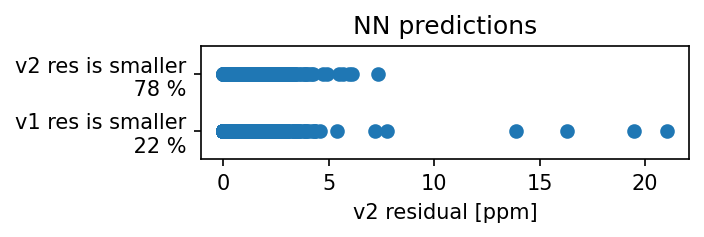

In [53]:
plt.figure(figsize=(4.2,1.0),dpi=150)
plt.title("NN predictions")
plt.scatter(corr_arr[:,1],corr_arr[:,0],marker="o")
#plt.ylabel("v2 res. > v1 res.",loc='bottom')
plt.xlabel("v2 residual [ppm]")
plt.yticks(ticks=[0.,1.],labels=["v1 res is smaller\n 22 %","v2 res is smaller\n 78 %"])
plt.ylim(-0.5,1.5)

In [68]:
corr_arr[:,1][corr_arr[:,0].astype(bool)]

array([1.40167088, 0.42493458, 0.71299035, ..., 0.91015849, 1.23487945,
       0.41213309])

In [63]:
import seaborn as sns

(0.0, 5.0)

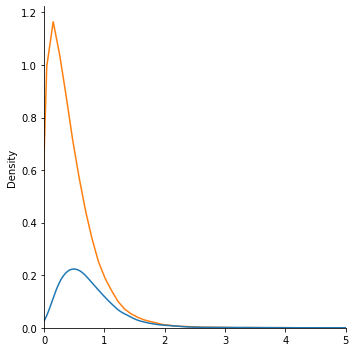

In [75]:
sns.displot(data=[corr_arr[:,1][corr_arr[:,0].astype(bool)],corr_arr[:,1][corr_arr[:,0].astype(bool)==False]],kind="kde",legend=False)
plt.xlim(0,5)

(-0.5, 1.5)

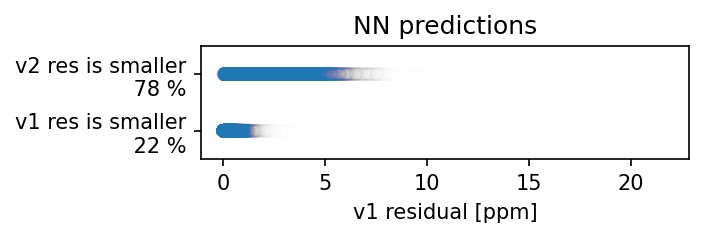

In [60]:
plt.figure(figsize=(4.2,1.0),dpi=150)
plt.title("NN predictions")
plt.scatter(corr_arr_v1[:,1],corr_arr_v1[:,0],facecolors='none', edgecolors='tab:blue',alpha=0.005)
#plt.ylabel("v2 res. > v1 res.",loc='bottom')
plt.xlabel("v1 residual [ppm]")
plt.yticks(ticks=[0.,1.],labels=["v1 res is smaller\n 22 %","v2 res is smaller\n 78 %"])
plt.ylim(-0.5,1.5)

In [ ]:
dis

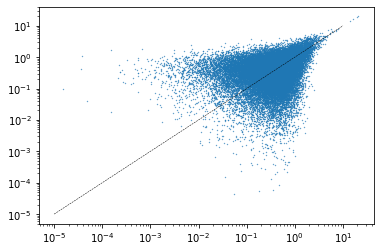

In [73]:
#np.abs(results_v2_NN[1][:,0]-results[1])
plt.scatter(np.abs(results_v2_NN[1][:,0]-results[1]),np.abs(results_v2_RR[1][:,0]-results[1]),s=0.1)
plt.plot(np.logspace(-5,1),np.logspace(-5,1),c="black",linewidth=0.5,linestyle="--")
plt.yscale("log")
plt.xscale("log")

In [162]:
params

{'1': {'alpha_v1': 2.1666221954826015,
  'alpha_v2': 1.9385516672672058,
  'beta_v1': 0.4966276097334276,
  'beta_v2': 0.30912548143969415,
  'gamma_v1': -1.2337890032550534,
  'gamma_v2': -1.218408962545645},
 '6': {'alpha_v1': 2.593933465599352,
  'alpha_v2': 1.6461095177300928,
  'beta_v1': 4.002534592902607,
  'beta_v2': 2.2469845074797155,
  'gamma_v1': -1.1680349884241088,
  'gamma_v2': -0.9281149536966569},
 '7': {'alpha_v1': 5.385116460926099,
  'alpha_v2': 2.8250480329461354,
  'beta_v1': 4.142458963443107,
  'beta_v2': 2.0531145563192856,
  'gamma_v1': -1.2471224895641495,
  'gamma_v2': -1.073791575960776},
 '8': {'alpha_v1': 448.7210308765337,
  'alpha_v2': 2.619530336657615,
  'beta_v1': 0.08911380492587437,
  'beta_v2': 7.272656929029733,
  'gamma_v1': -1.6225751426854187,
  'gamma_v2': -1.1046379302921503}}

In [164]:
params_RR

{'1': {'alpha_v1': 30.872304306853003,
  'alpha_v2': 2.512588943941435,
  'beta_v1': 0.4688394705027421,
  'beta_v2': 0.3817023436057139,
  'gamma_v1': -1.51627505607387,
  'gamma_v2': -1.0900947829642456},
 '6': {'alpha_v1': 1586.0502147483608,
  'alpha_v2': 2.578425498568291,
  'beta_v1': 0.00023051593978880161,
  'beta_v2': 3.1812477498478344,
  'gamma_v1': -1.6352184281670774,
  'gamma_v2': -1.0173576117869874},
 '7': {'alpha_v1': 310.07443926585466,
  'alpha_v2': 2.8786426597246115,
  'beta_v1': 7.606464920640537,
  'beta_v2': 5.136348837366332,
  'gamma_v1': -1.4385938607352868,
  'gamma_v2': -0.9281421818475443},
 '8': {'alpha_v1': 543.3625109065784,
  'alpha_v2': 1.6686755472887103,
  'beta_v1': -12.961511345954136,
  'beta_v2': 11.749234743568888,
  'gamma_v1': -1.462300446593936,
  'gamma_v2': -0.821680463716305}}

In [28]:
params.keys()

dict_keys(['1', '6', '7', '8'])

In [44]:
for specie in [1,6,7,8]:
    print(mean_squared_error(results_v2[specie][:,0],results[specie],squared=False))

NameError: name 'results_v2' is not defined

## MD trajectories - trail removed ?

In [88]:
md_traj_glycine_transformed = read("../example_trajectories/test_traj_w_cs.xyz",format="extxyz",index=":")

for frame in md_traj_glycine_transformed: frame.wrap(eps=1e-12)
for frame in md_traj_glycine_transformed: del frame.arrays["center_atoms_mask"]
results_md = {}

for specie in [1,6]:
    tmp = []
    for frame in md_traj_glycine_transformed:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp.append(frame.arrays["CS"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results_md[specie] = np.hstack(tmp) 

In [91]:
pred_md = model_v2_NN.predict(md_traj_glycine_transformed)

pred_md_RR = model_v2_RR.predict(md_traj_glycine_transformed)

(5412, 16)
(5412, 16)


In [92]:
pred_md

{1: array([[2.44089953e+01, 2.16287662e-02],
        [2.24638727e+01, 6.13859457e-02],
        [2.31637441e+01, 2.87569833e-02],
        ...,
        [2.40187917e+01, 1.21941618e-02],
        [2.33749846e+01, 1.65907778e-02],
        [2.33990326e+01, 2.99286563e-02]]),
 6: array([[28.27174523,  7.78824074],
        [24.79774605,  9.86748732],
        [38.17474733,  3.63034232],
        ...,
        [46.06623877,  4.05040234],
        [36.91222461,  6.18530742],
        [45.09851126,  9.67864497]])}

In [101]:
from sklearn.metrics import mean_absolute_error

In [116]:
for specie in [1,6]:
    print("1H" if specie == 1 else "13C")
    print("NN MAE: {:.2f}".format(mean_absolute_error(pred_md[specie][:,0],results_md[specie])))
    print("RR MAE: {:.2f}".format(mean_absolute_error(pred_md_RR[specie][:,0],results_md[specie])))
    print("NN RMSE: {:.2f}".format(mean_squared_error(pred_md[specie][:,0],results_md[specie],squared=False)))
    print("RR RMSE: {:.2f}".format(mean_squared_error(pred_md_RR[specie][:,0],results_md[specie],squared=False)))
    print("combined RMSE {:.2f}".format(mean_squared_error(results_combined_MD[specie],results_md[specie],squared=False)))
    print("combined MAE {:.2f}".format(mean_absolute_error(results_combined_MD[specie],results_md[specie])))

1H
NN MAE: 0.48
RR MAE: 0.67
NN RMSE: 0.63
RR RMSE: 0.88
combined RMSE 0.58
combined MAE 0.45
13C
NN MAE: 9.55
RR MAE: 6.15
NN RMSE: 11.76
RR RMSE: 7.92
combined RMSE 8.99
combined MAE 7.12


In [113]:
results_combined_MD = {}

for specie in [1,6]:
    
    specie = str(specie)
    
    alpha_v1 = params_RR[specie]["alpha_v2"]
    alpha_v2 = params_NN[specie]["alpha_v2"]
    beta_v1 = params_RR[specie]["beta_v2"]
    beta_v2 = params_NN[specie]["beta_v2"]
    gamma_v1 = params_RR[specie]["gamma_v2"]
    gamma_v2 = params_NN[specie]["gamma_v2"]
    
    v1_raw = pred_md_RR[int(specie)]
    v2_raw = pred_md[int(specie)]
    
    pred_comb = combined_pred(v1_raw,v2_raw,alpha_v1,alpha_v2,beta_v1,beta_v2,gamma_v1,gamma_v2)
    
    results_combined_MD[int(specie)] = pred_comb

In [148]:
import seaborn as sns
from matplotlib import pyplot as plt

In [128]:
sns.set(rc={"figure.figsize":(4.2, 2.6),"figure.dpi":300})

([], [])

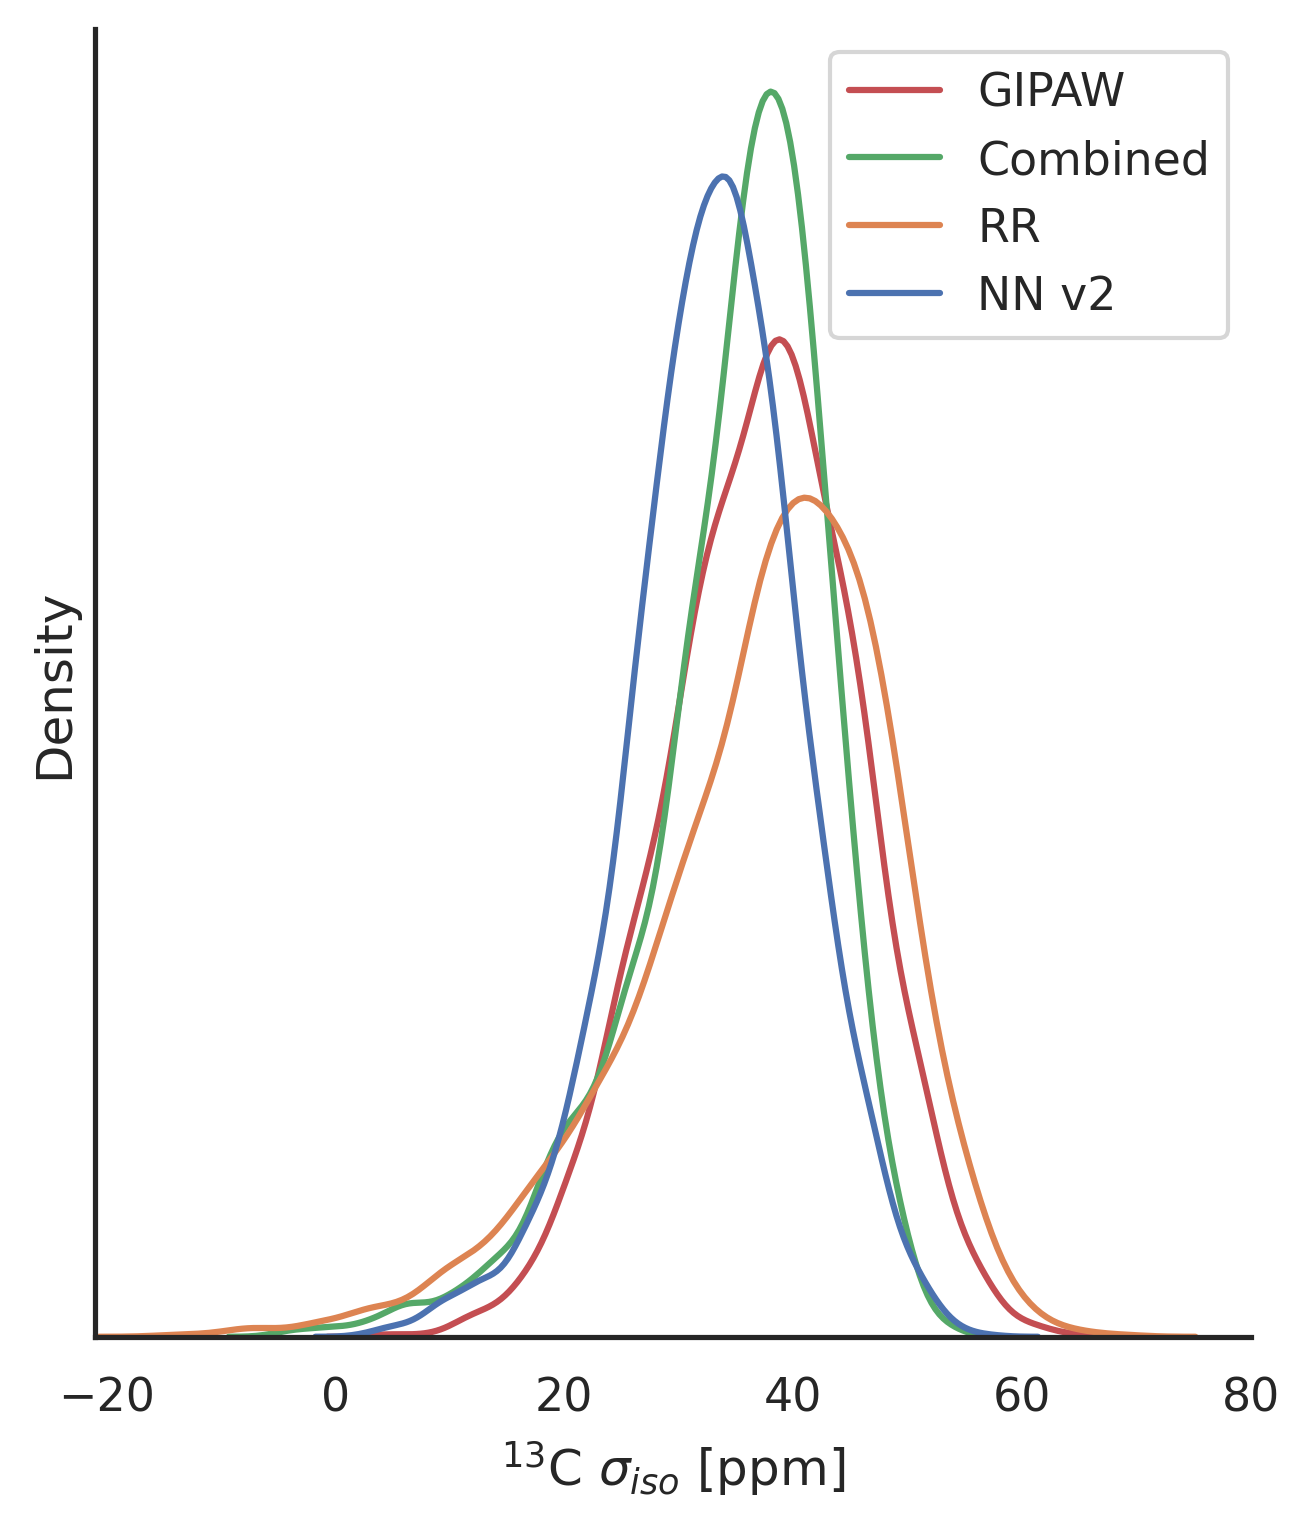

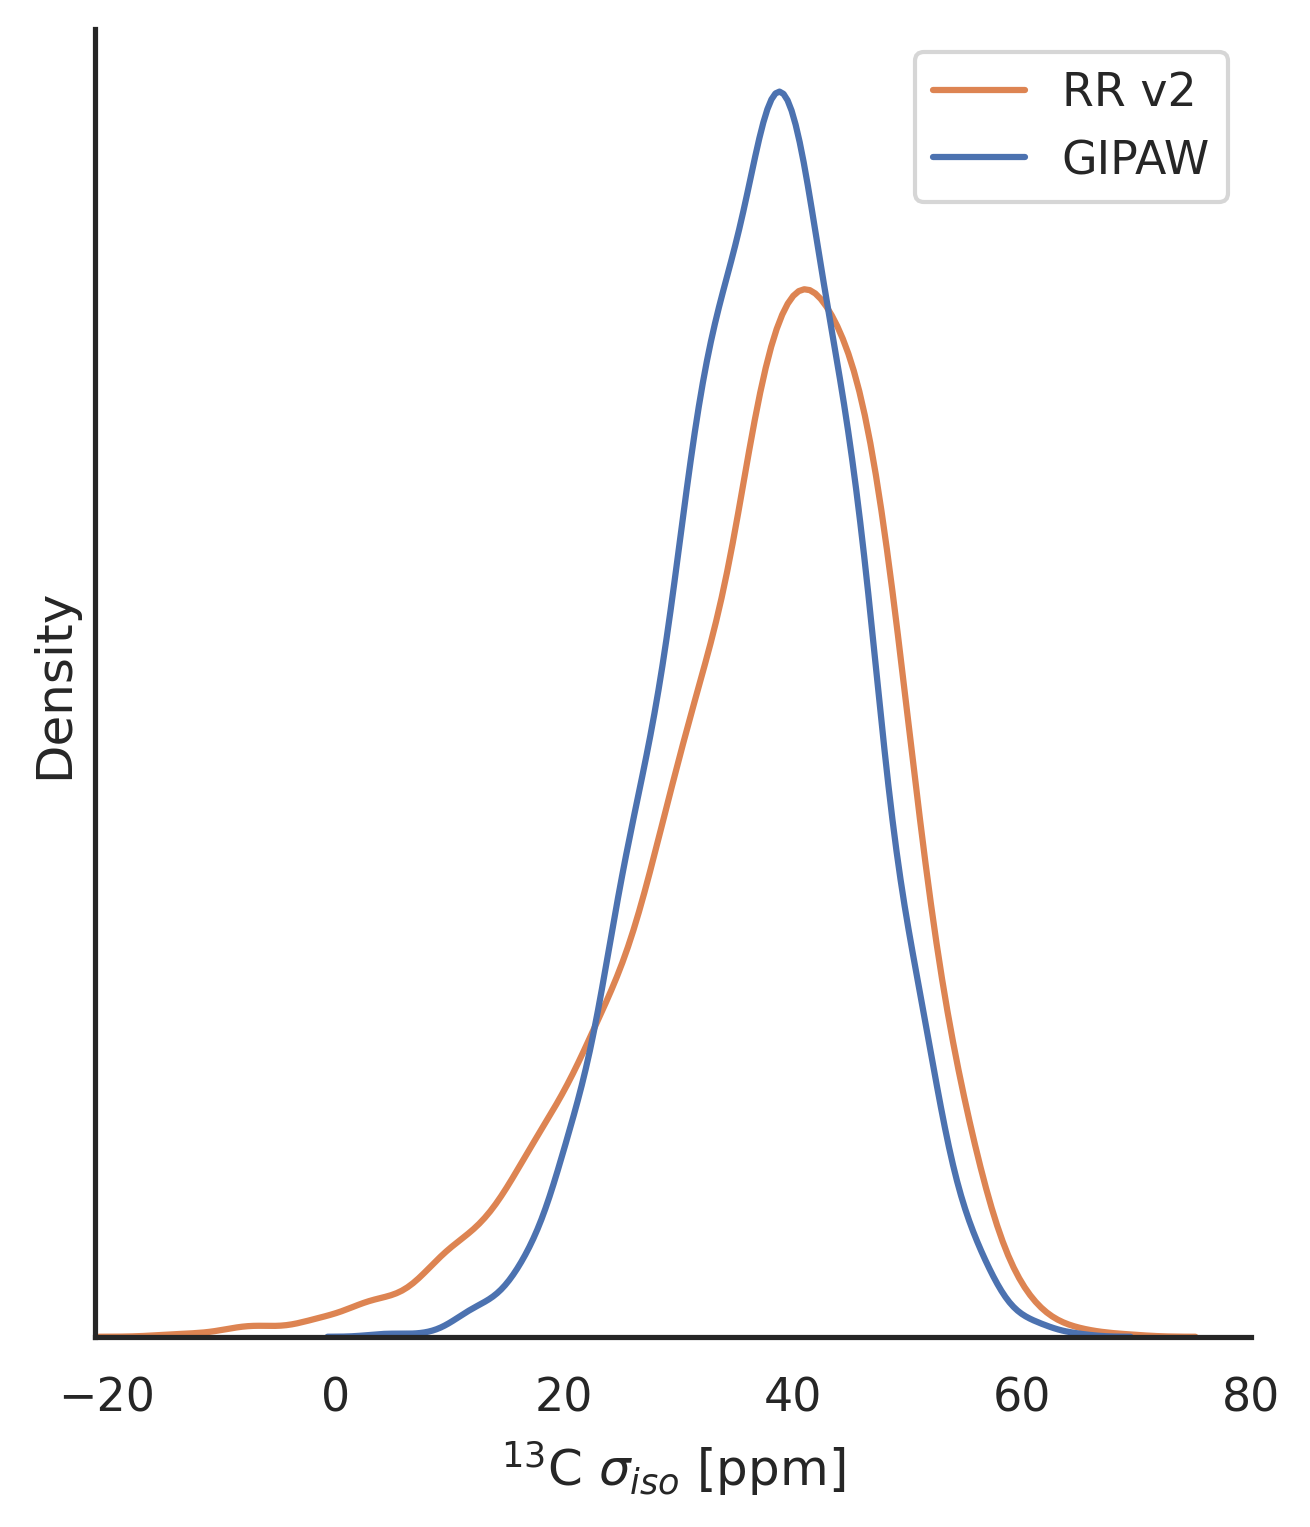

In [135]:
#plt.figure(figsize=(4.2,2.6),dpi=300)#,dpi=300)
sns.set_style("white")
sns.displot(data=np.vstack([pred_md[6][:,0],pred_md_RR[6][:,0],results_combined_MD[6],results_md[6]]).T,kind="kde",legend=False,)
#sns.displot(data=np.vstack([results_md[6],results_combined_MD[6]]).T,kind="kde",legend=False,)

#plt.legend(["NN v2","Combined", "RR", "GIPAW"])
plt.legend(["GIPAW","Combined","RR","NN v2"])
plt.xlim(-21,80)
plt.xlabel(r"$^{13}$C $\sigma_{iso}$ [ppm]")
plt.yticks([])
plt.plot()
sns.displot(data=np.vstack([results_md[6],pred_md_RR[6][:,0]]).T,kind="kde",legend=False)
plt.legend(["RR v2","GIPAW"])
plt.xlim(-21,80)
plt.xlabel(r"$^{13}$C $\sigma_{iso}$ [ppm]")
plt.yticks([])

([], [])

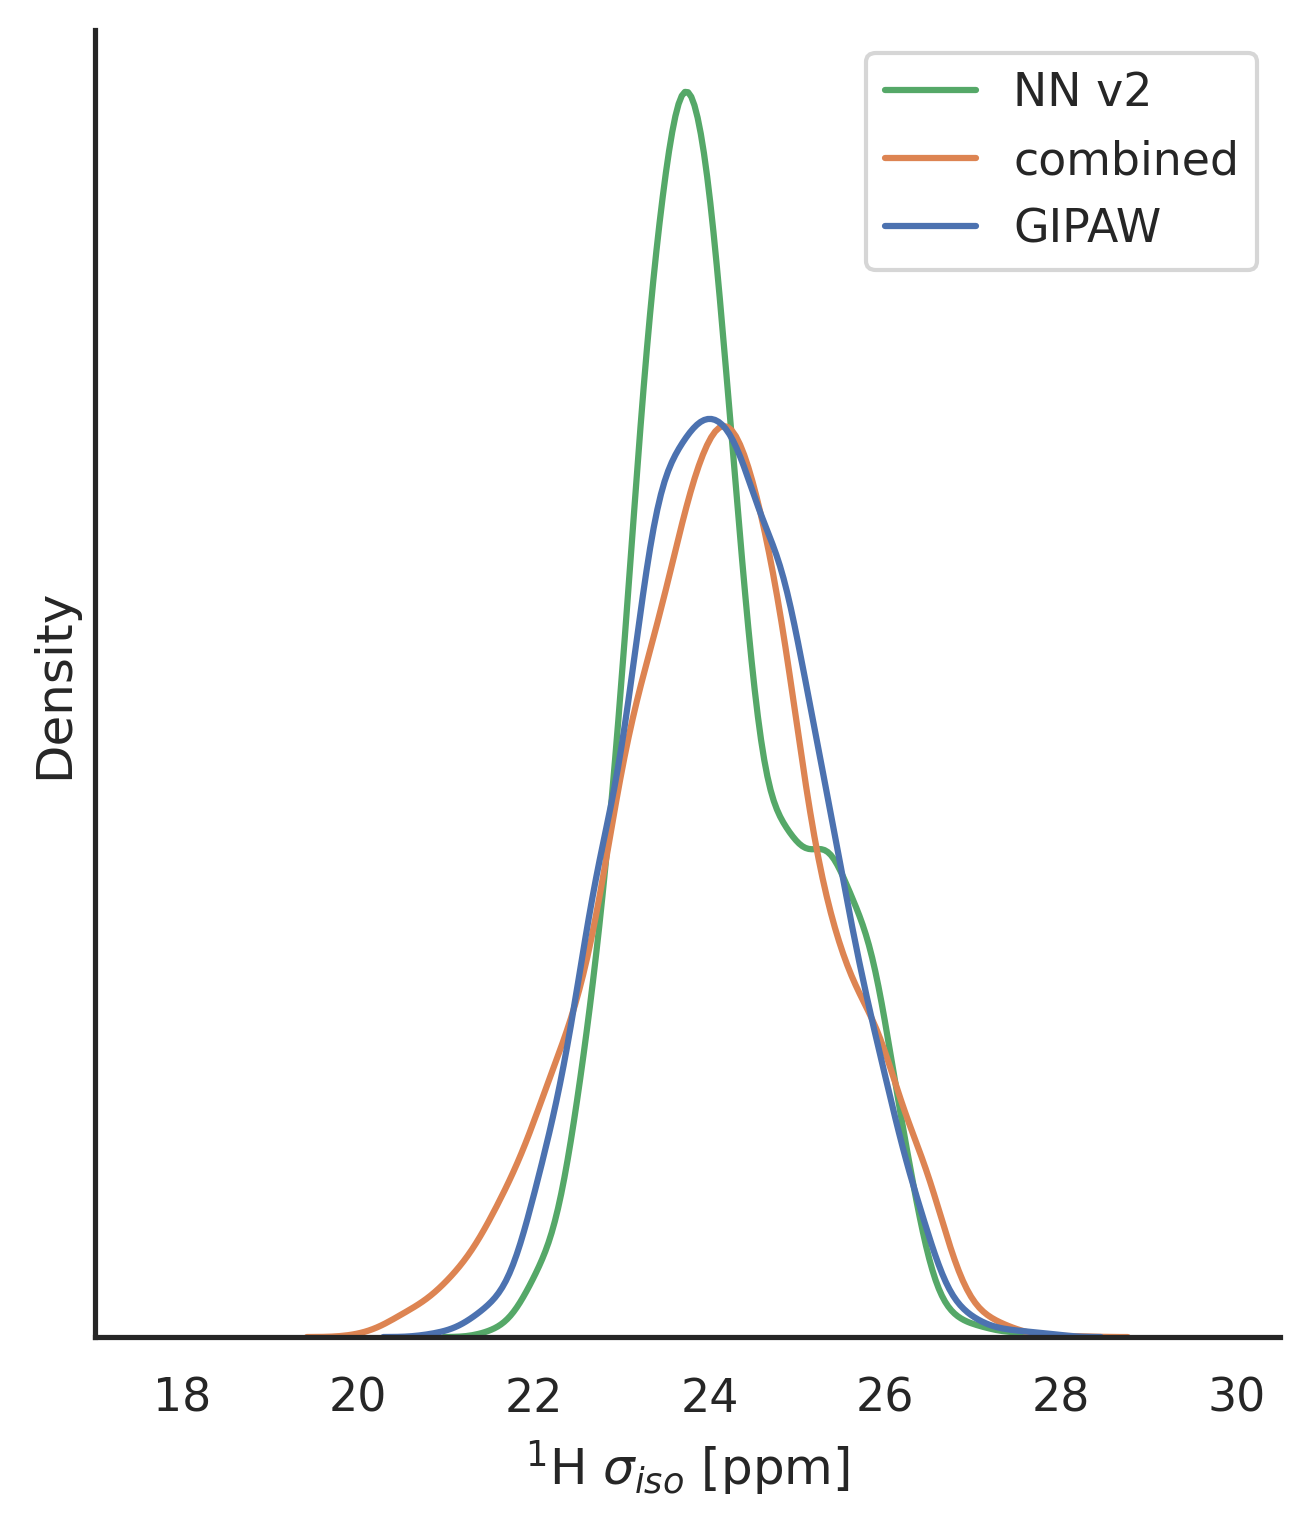

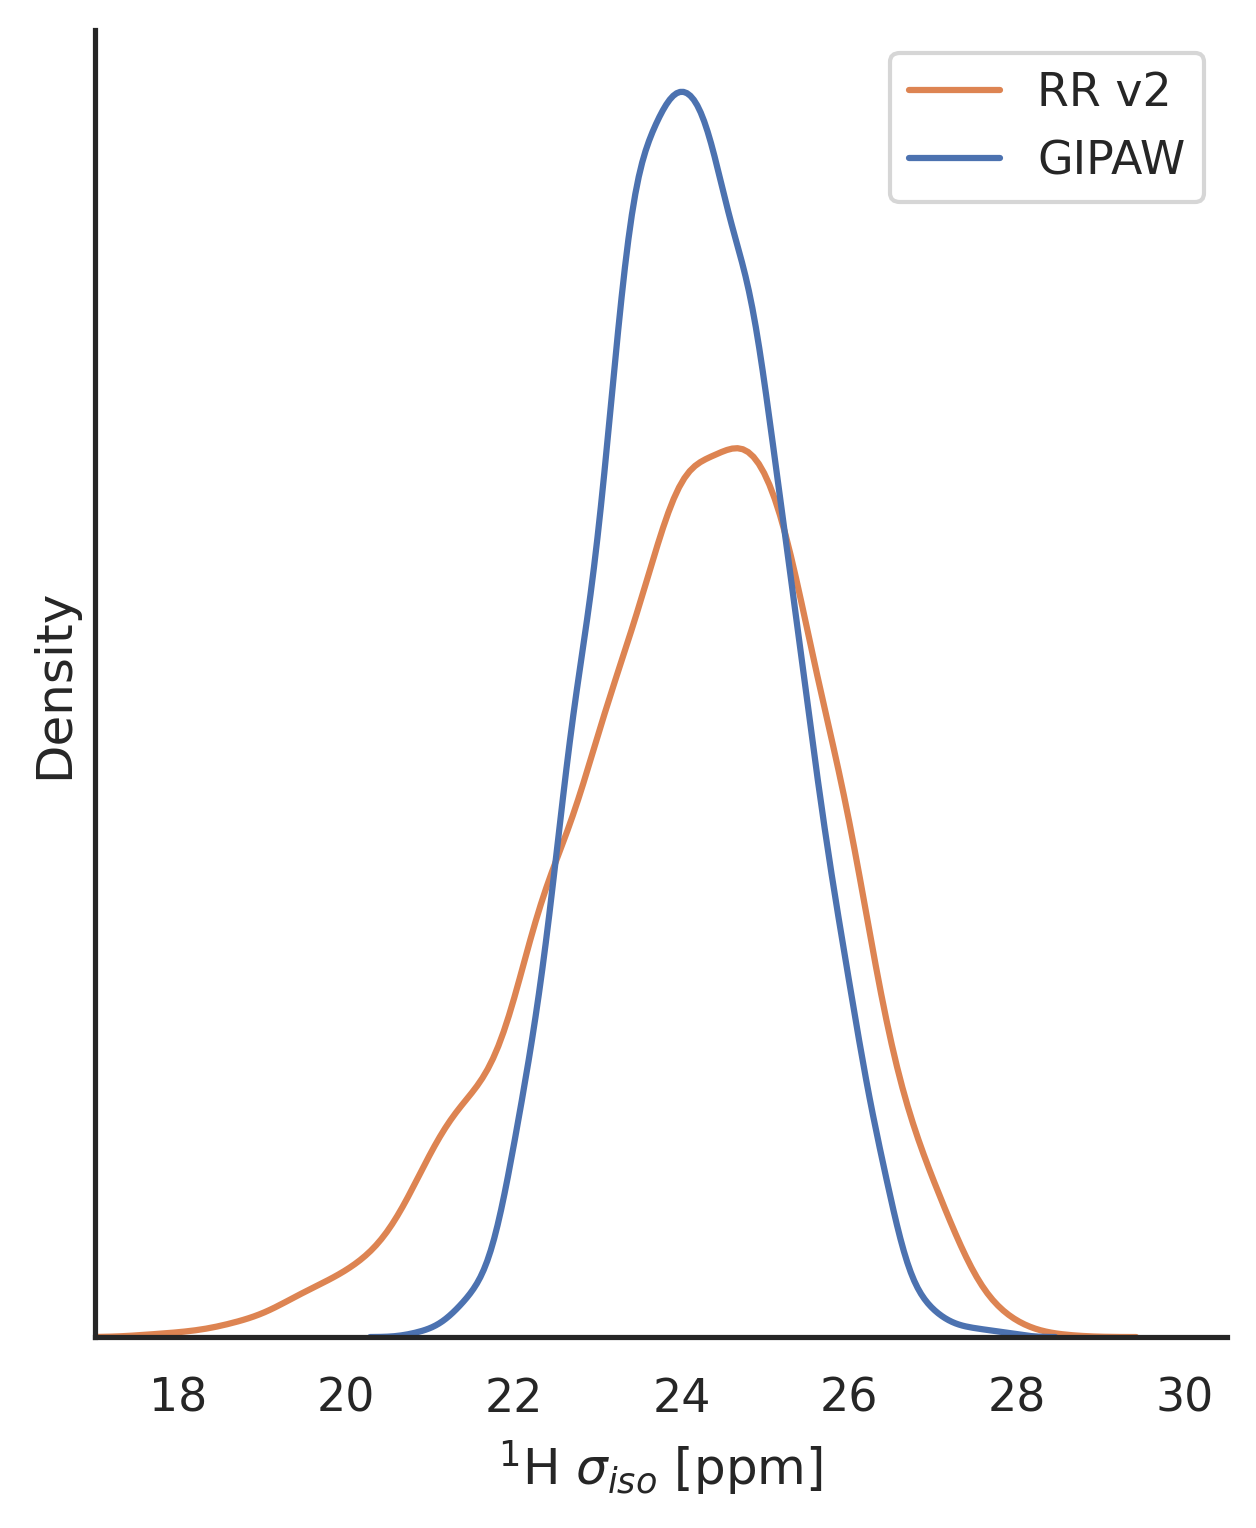

In [129]:
#plt.figure(figsize=(4.2,2.6),dpi=300)#,dpi=300)
sns.set_style("white")
sns.displot(data=np.vstack([results_md[1],results_combined_MD[1],pred_md[1][:,0]]).T,kind="kde",legend=False,)

plt.legend(["NN v2","combined","GIPAW"])
plt.xlim(17.,30.5)
plt.xlabel(r"$^{1}$H $\sigma_{iso}$ [ppm]")
plt.yticks([])
#plt.plot()
sns.displot(data=np.vstack([results_md[1],pred_md_RR[1][:,0]]).T,kind="kde",legend=False)
plt.legend(["RR v2","GIPAW"])
plt.xlim(17.,30.5)
plt.xlabel(r"$^{1}$H $\sigma_{iso}$ [ppm]")
plt.yticks([])

(17.0, 30.5)

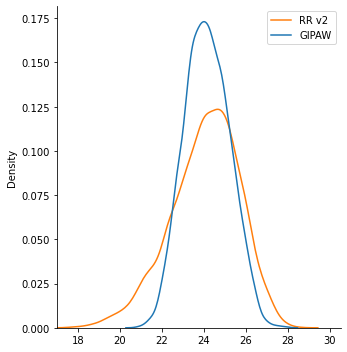

/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 6.79999999999999, '$\\sigma_{iso}$')

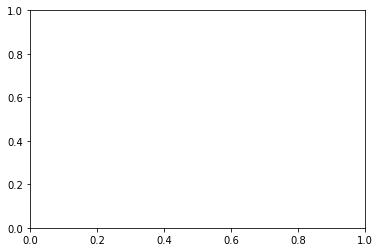

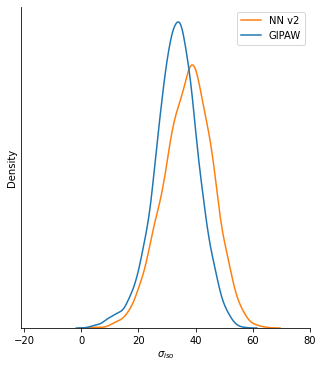

In [142]:
fig, ax = plt.subplots()
sns.displot(data=np.vstack([pred_md[6][:,0],results_md[6]]).T,kind="kde",legend=False)
plt.legend(["NN v2","GIPAW"])
plt.xlim(-21,80)
plt.yticks([])
plt.xlabel(r"$\sigma_{iso}$")

(-21.0, 80.0)

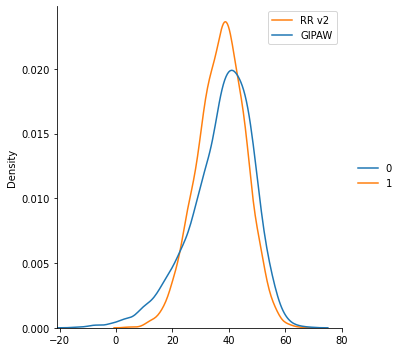

In [123]:
sns.displot(np.vstack([pred_md_RR[6][:,0],results_md[6]]).T,kind="kde")
plt.legend(["RR v2","GIPAW"])
plt.xlim(-21,80)

<Figure size 1800x1200 with 0 Axes>

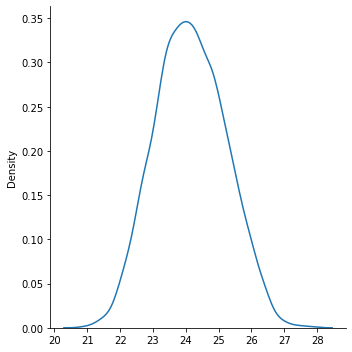

In [144]:
plt.figure(dpi=300)
sns.displot(results_md[1],kind="kde")

## Building and trying neighbourlists

In [85]:
testframe = frames[0]

In [87]:
testframe

Atoms(symbols='C34H50N2', pbc=True, cell=[[4.6642, 0.0, 0.0], [0.0, 7.831, 0.0], [-0.406389452349, 0.0, 20.6029924189]], CS_local=..., CS_total=..., center_atoms_mask=...)

In [88]:
from ase.neighborlist import build_neighbor_list

In [91]:
neighbourlist = build_neighbor_list(testframe,cutoffs=[2.0 for i in range(len(testframe))])

In [93]:
connect = neighbourlist.get_connectivity_matrix()

In [96]:
neighbourlist.get_neighbors(1)

(array([14,  2, 18,  6, 10,  1, 11, 15,  3, 19, 27,  0, 12,  8, 20, 16,  5,
         9, 24,  7, 22, 14,  6, 13,  3,  5]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1]]))

## Building MC dropout models

In [3]:
!export OMP_NUM_THREADS=8

In [74]:
rr_dropout = ShiftMLRR_dropout(dropout_probability=0.1,dropout_runs=64,bodyorder="v2",renorm=False,dropout=True,noise=False)


In [5]:
%pwd

'/ssd/scratch/kellner/COSMO_project/uncertainty'

In [ ]:
ShiftML-Light/src/lshiftml/models/RR_model_data/RR_this_work_models/hypers/6_hypers.json

In [75]:
pred = rr_dropout.predict(frames)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [4]:
pred = rr_dropout.predict(frames)

  0%|          | 0/64 [00:00<?, ?it/s]

[ 8.43412770e-01  1.17638822e-02  0.00000000e+00 -1.39565689e-03
  9.20442036e-04  0.00000000e+00 -4.77776666e-04 -2.36405512e-05
  2.10311126e-05  1.23238451e-01  3.56150425e-03  6.67582940e-03
 -0.00000000e+00  5.11929523e-04 -1.41824671e-05 -7.52364317e-04
  5.67951375e-04  4.92202388e-06  4.58330213e-02  3.04375135e-03
 -0.00000000e+00  4.95464870e-03  2.96494560e-03  1.53694844e-03
 -1.11716473e-05]
[ 8.43412770e-01  1.17638822e-02  1.00011740e-02 -1.39565689e-03
  9.20442036e-04  5.11024825e-04 -4.77776666e-04 -2.36405512e-05
  2.10311126e-05  1.23238451e-01  3.56150425e-03  6.67582940e-03
 -2.11651608e-03  5.11929523e-04 -1.41824671e-05 -7.52364317e-04
  5.67951375e-04  4.92202388e-06  4.58330213e-02  3.04375135e-03
 -2.47704770e-03  4.95464870e-03  2.96494560e-03  1.53694844e-03
 -1.11716473e-05]
True
False
[ 8.43412770e-01  1.17638822e-02  1.00011740e-02 -1.39565689e-03
  9.20442036e-04  5.11024825e-04 -4.77776666e-04 -2.36405512e-05
  2.10311126e-05  1.23238451e-01  3.5615042

KeyboardInterrupt: 

In [77]:
#results_mult = {}

for specie in [1,6,7,8]:
    print(mean_squared_error(np.mean(pred[specie]["avg"],axis=1),results[specie],squared=False))
    #results_mult[specie] = {"avg":np.load("{}_noise_rescale_prediction.npy".format(specie))}

0.9537184275807906
10.612914768510734
130.26486184264638
36.12847592305447


In [10]:
from matplotlib import pyplot as plt

In [6]:
np.mean(pred[6]["avg"],axis=1)

array([31.614926  , 33.30875972, 40.60296417, ..., 24.7703792 ,
       30.93261549, 30.55101802])

In [21]:
import seaborn as sns

In [36]:
8*8

64

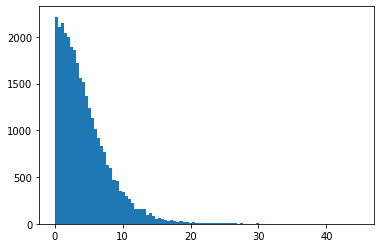

In [33]:
_ = plt.hist(np.abs(np.average(pred[6]["avg"],axis=1)-results[6]),bins=100)

Text(0.5, 1.0, 'Feature dropout (p=10%)')

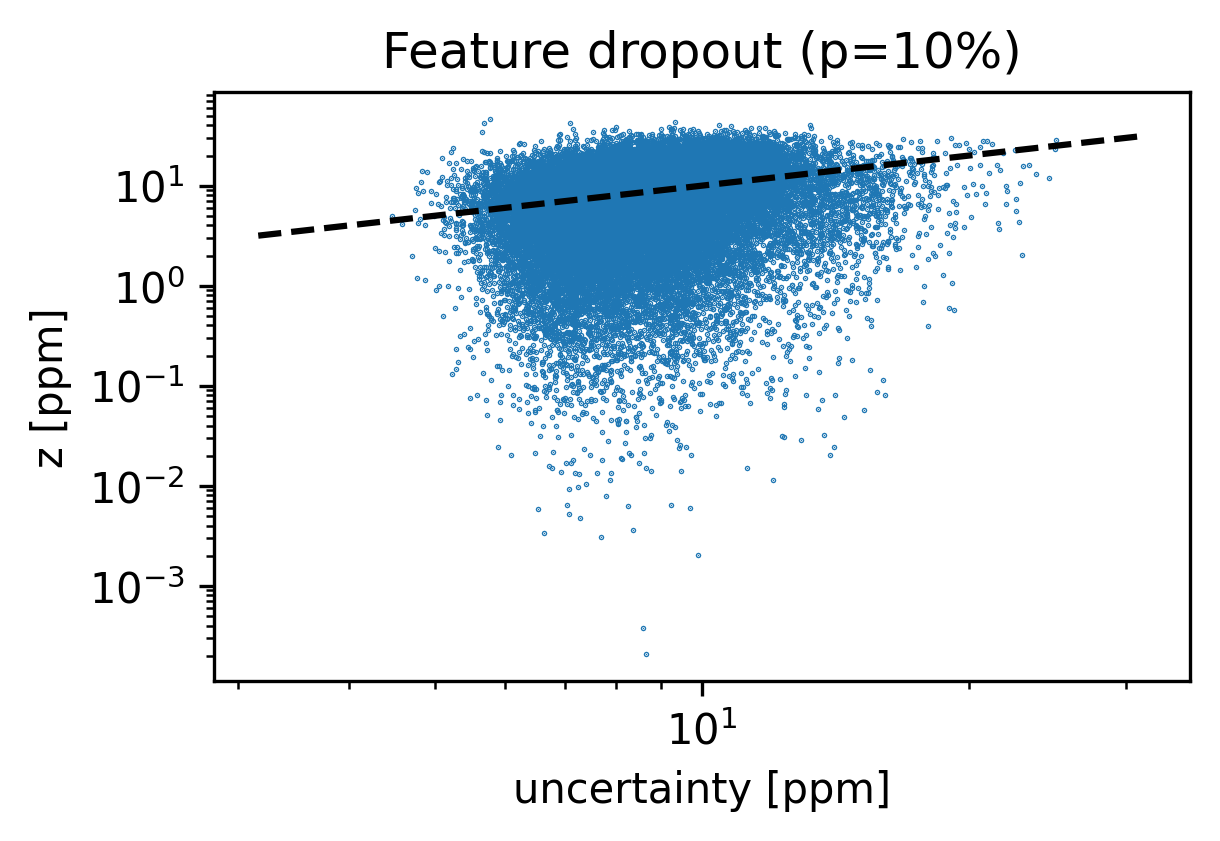

In [87]:
specie = 6
plt.figure(dpi=300,figsize=(4.2,2.6))
plt.plot(np.logspace(0.5,1.5),np.logspace(0.5,1.5),c="black",linestyle="--")
#plt.xlim(4,20)
plt.scatter(0.2*np.std(pred[specie]["avg"],axis=1,ddof=1)**1,np.abs(np.average(pred[specie]["avg"],axis=1)-results[specie]),s=0.1)
plt.xlabel("uncertainty [ppm]")
plt.ylabel("z [ppm]")
plt.yscale("log")
plt.xscale("log")
plt.title("Feature dropout (p=10%)")

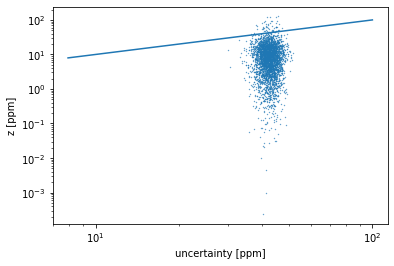

In [60]:
specie = 7

plt.plot(np.logspace(0.9,2),np.logspace(0.9,2))
plt.scatter(np.std(results_mult[specie]["avg"],axis=1,ddof=1),np.abs(np.average(results_mult[specie]["avg"],axis=1)-results[specie]),s=0.1)
plt.xlabel("uncertainty [ppm]")
plt.ylabel("z [ppm]")
plt.yscale("log")
plt.xscale("log")

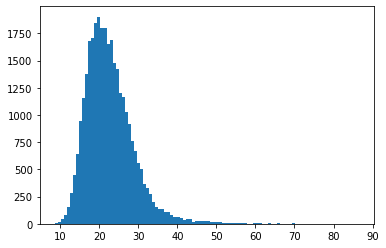

In [69]:
_ = plt.hist(np.std(pred[6]["avg"],axis=1,ddof=1),bins=100)


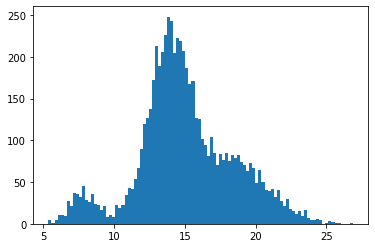

In [18]:
_ = plt.hist(np.std(pred[8]["avg"],axis=1,ddof=1),bins=100)

In [6]:
import joblib

In [7]:
clf = joblib.load("./multi_ridge_v2/1_15_name_clf")

In [12]:
clf.best_estimator_

Ridge(alpha=0.001)

In [46]:
Xpredict = np.ones(100).reshape((10,10))
rnd_mask = np.random.uniform(low=0., high=1., size=Xpredict.shape) > 0.2
rnd_sum_dropout = Xpredict.shape[0] - np.sum(rnd_mask,axis=1)
dropout_probab = rnd_sum_dropout/Xpredict.shape[0]
rescaling = 1/(1-dropout_probab)
Xpredict = Xpredict * rnd_mask
Xpredict = Xpredict*rescaling[:, np.newaxis]
colum_sum = np.sum(Xpredict,axis=1)

In [48]:
colum_sum

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [40]:
rescaling

array([1.25      , 1.42857143, 1.11111111, 1.11111111, 1.11111111,
       1.25      , 1.25      , 2.        , 1.25      , 1.25      ])

In [25]:
dropout_probab = rnd_sum_dropout/Xpredict.shape[0]

In [28]:
rnd_sum_dropout

array([3, 2, 2, 3, 5, 0, 1, 1, 0, 1])

In [29]:
dropout_probab

array([0.3, 0.2, 0.2, 0.3, 0.5, 0. , 0.1, 0.1, 0. , 0.1])

In [21]:
rnd_mask[0]

array([ True,  True,  True, False,  True,  True,  True, False, False,
        True])

In [47]:
Xpredict

array([[1.42857143, 0.        , 0.        , 1.42857143, 0.        ,
        1.42857143, 1.42857143, 1.42857143, 1.42857143, 1.42857143],
       [1.42857143, 0.        , 0.        , 1.42857143, 1.42857143,
        1.42857143, 1.42857143, 1.42857143, 1.42857143, 0.        ],
       [0.        , 0.        , 1.66666667, 1.66666667, 0.        ,
        1.66666667, 1.66666667, 1.66666667, 1.66666667, 0.        ],
       [1.11111111, 1.11111111, 1.11111111, 0.        , 1.11111111,
        1.11111111, 1.11111111, 1.11111111, 1.11111111, 1.11111111],
       [1.66666667, 1.66666667, 0.        , 0.        , 1.66666667,
        0.        , 1.66666667, 1.66666667, 0.        , 1.66666667],
       [1.42857143, 1.42857143, 1.42857143, 0.        , 0.        ,
        1.42857143, 1.42857143, 0.        , 1.42857143, 1.42857143],
       [1.42857143, 1.42857143, 0.        , 1.42857143, 1.42857143,
        1.42857143, 1.42857143, 0.        , 1.42857143, 0.        ],
       [1.25      , 1.25      , 1.25     

In [10]:
with open("../../ShiftML-Light/src/lshiftml/models/RR_model_data/RR_this_work_models/hypers/1_hypers.json","r") as fg:
    hypers = json.load(fg)

In [11]:
from rascal.representations import SphericalInvariants as SOAP

In [12]:
soap = SOAP(**hypers)

In [19]:
for frame in frames: frame.arrays.pop("center_atoms_mask")

In [20]:
X_train = soap.transform(frames).get_features(soap)

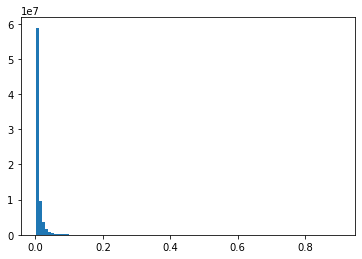

In [27]:
_ = plt.hist(X_train.flatten()[X_train.flatten() > 0.001],bins=100)

In [28]:
np.mean(X_train.flatten()[X_train.flatten() > 0.001])

0.009448532428691012

In [17]:
X_train.shape

(6346, 8640)

In [59]:
rnd_mask = np.random.uniform(low=0., high=1., size=X_train.shape) > 0.2
X_train_masked = X_train * rnd_mask

In [55]:
np.sum(X_train,axis=1)

array([3.2497819 , 3.24790593, 3.24977488, 3.24791627, 3.11672737,
       3.11663846, 3.11673456, 3.11662211, 2.46395244, 2.46297057,
       2.46395272, 2.46297827, 2.71988602, 2.71843073, 2.71988768,
       2.71842047])

In [ ]:
np.sum(X_train_masked,axis=1)

## Renormalize feats

In [61]:
np.linalg.norm(X_train,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [62]:
np.linalg.norm(X_train_masked,axis=1)

array([0.83641156, 0.90042846, 0.93387144, 0.90858668, 0.84964507,
       0.84585618, 0.91091844, 0.86383389, 0.94407071, 0.85389982,
       0.90502242, 0.94211598, 0.8951108 , 0.89630195, 0.89952109,
       0.94780208])

By renorming the features we preserve something?

In [65]:
np.linalg.norm(X_train_masked/np.linalg.norm(X_train_masked,axis=1)[:,np.newaxis],axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
np.average(X_train)

NameError: name 'X_train' is not defined

In [15]:
X_train

array([[0.0423432 , 0.07493244, 0.07032665, ..., 0.        , 0.        ,
        0.        ],
       [0.04235418, 0.07476317, 0.0703736 , ..., 0.        , 0.        ,
        0.        ],
       [0.042343  , 0.07493307, 0.07032731, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03602151, 0.01060141, 0.00869458, ..., 0.        , 0.        ,
        0.        ],
       [0.03606583, 0.0106134 , 0.0086908 , ..., 0.        , 0.        ,
        0.        ],
       [0.03602249, 0.01060109, 0.00869425, ..., 0.        , 0.        ,
        0.        ]])

## using min(eps,feat_value) ?